In [1]:
import os
import sys
import networkx as nx
import numpy as np
from epynet import Network

sys.path.insert(0, os.path.join('..', 'utils'))
from graph_utils import get_nx_graph

In [2]:
wds_id = 'anytown'

In [3]:
path_to_data = os.path.join('..', 'data', 'db_'+wds_id+'_doe_pumpfed_1')
path_to_wds = os.path.join('..', 'water_networks', wds_id+'.inp')

### Loading WDS topology

In [4]:
wds = Network(path_to_wds)
G = get_nx_graph(wds, mode='weighted')

In [5]:
coords = {}
for node in wds.nodes:
    arr = [node.coordinates[0], node.coordinates[1]]
    coords[int(node.index)] = arr

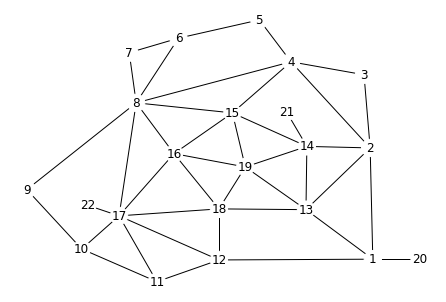

In [6]:
node_colors = ['#ffffff' for _ in G.nodes]
nx.draw(G, pos=coords, with_labels=True, node_color=node_colors)

### Collecting master nodes

In [7]:
master_nodes = set()
for tank in wds.tanks:
    node_a = wds.links[list(tank.links.keys())[0]].from_node.index
    node_b = wds.links[list(tank.links.keys())[0]].to_node.index
    if node_a in set(G.nodes):
        master_nodes.add(node_a)
    elif node_b in set(G.nodes):
        master_nodes.add(node_b)
    else:
        print(tank)

for reservoir in wds.reservoirs:
    links = reservoir.links
    for link in links:
        node_a = wds.links[link.uid].from_node.index
        node_b = wds.links[link.uid].to_node.index
    if node_a in set(G.nodes):
        master_nodes.add(node_a)
    elif node_b in set(G.nodes):
        master_nodes.add(node_b)
    else:
        print(reservoir)
        
# for pump in wds.pumps:
#     master_nodes.add(pump.to_node.index)

### Shortest path selection

In [8]:
sensor_budget = 5
sensor_nodes = set()

In [9]:
for _ in range(sensor_budget):
    path_lengths = dict()
    for node in G.nodes:
        path_lengths[node] = 0
    for node in master_nodes.union(sensor_nodes):
        tempo = nx.shortest_path_length(G, source=node, weight='weight')
#         tempo = nx.shortest_path_length(G, source=node, weight=None)
        for key, value in tempo.items():
            if key not in master_nodes.union(sensor_nodes):
                path_lengths[key] += value
    sensor_nodes.add([candidate for candidate, path_length in path_lengths.items() 
                      if path_length == np.max(list(path_lengths.values()))][0])

### Sensor placement plot

In [10]:
node_arr = np.array(G.nodes)
for node in master_nodes:
    try:
        node_colors[np.where(node_arr == node)[0][0]] = '#ff0000'
    except:
        print(node)
for node in sensor_nodes:
    node_colors[np.where(node_arr == node)[0][0]] = '#008000'

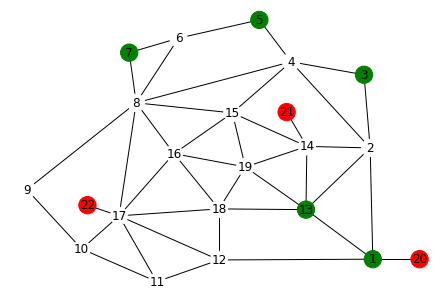

In [11]:
nx.draw(G, pos=coords, with_labels=True, node_color=node_colors, alpha=None)

### Sensitivity matrix

In [12]:
wds.solve()

delta_demand = np.max(wds.junctions.basedemand)/100
base_demands = wds.junctions.basedemand
base_heads = wds.junctions.head
S = np.zeros((len(wds.junctions), len(wds.junctions)), dtype=np.float64)

In [13]:
for i, junc in enumerate(wds.junctions):
    wds.junctions.basedemand = base_demands
    junc.basedemand += delta_demand
    wds.solve()
    S[i, :] = (wds.junctions.head-base_heads) / base_heads

In [14]:
print(np.min(S))
print(np.max(S))

-0.004836452185245255
-1.103811885544813e-10
